In [3]:
import pandas as pd
import numpy as np
import warnings
import os
import seaborn as sns
import matplotlib.pyplot as plt
"""
sns 相关设置
@return:
"""
# 声明使用 Seaborn 样式
sns.set()
# 有五种seaborn的绘图风格，它们分别是：darkgrid, whitegrid, dark, white, ticks。默认的主题是darkgrid。
sns.set_style("whitegrid")
# 有四个预置的环境，按大小从小到大排列分别为：paper, notebook, talk, poster。其中，notebook是默认的。
sns.set_context('talk')
# 中文字体设置-黑体
plt.rcParams['font.sans-serif'] = ['SimHei']
# 解决保存图像是负号'-'显示为方块的问题
plt.rcParams['axes.unicode_minus'] = False
# 解决Seaborn中文显示问题并调整字体大小
sns.set(font='SimHei')

In [4]:
from utils_jessie import reduce_mem_usage

In [5]:
data = pd.read_csv('user_data/data_for_model.csv')

In [6]:
data = reduce_mem_usage(data)

Memory usage of dataframe is 440.60 MB
Memory usage after optimization is: 288.01 MB
Decreased by 34.6%


In [7]:
from sklearn.model_selection import KFold

# 分离数据集
features = [f for f in data.columns if f not in ['id','issueDate','isDefault']]

train = data[data.isDefault.notnull()].reset_index(drop=True)
test = data[data.isDefault.isnull()].reset_index(drop=True)

X_train = train[features]
X_test = test[features]

y_train = train['isDefault']

# 5折交叉验证
folds = 5
seed = 2025
kf = KFold(n_splits=folds, shuffle=True, random_state=seed)

In [8]:
"""对训练集数据进行划分，分成训练集和验证集，并进行相应的操作"""
from sklearn.model_selection import train_test_split
import lightgbm as lgb

# 数据集划分
X_train_split, X_val, y_train_split, y_val = train_test_split(X_train, y_train, test_size=0.2)
train_matrix = lgb.Dataset(X_train_split, label=y_train_split)
valid_matrix = lgb.Dataset(X_val, label=y_val)


In [10]:
params = {
            'boosting_type': 'gbdt',
            'objective': 'binary',
            'learning_rate': 0.1,
            'metric': 'auc',
            'min_child_weight': 1e-3,
            'num_leaves': 31,
            'max_depth': -1,
            'reg_lambda': 0,
            'reg_alpha': 0,
            'feature_fraction': 1,
            'bagging_fraction': 1,
            'bagging_freq': 0,
            'seed': 2025,
            'nthread': 8,
            'silent': True,
            'verbose': -1,
            'device': 'gpu'
}

In [13]:
model = lgb.train(params,train_set=train_matrix, valid_sets=valid_matrix,num_boost_round=20000,callbacks=[lgb.early_stopping(stopping_rounds=200),lgb.log_evaluation(1000)])

Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[538]	valid_0's auc: 0.726989


对验证集进行预测



未调参前lightgbm单模型在验证集上的AUC：0.7269890160490498


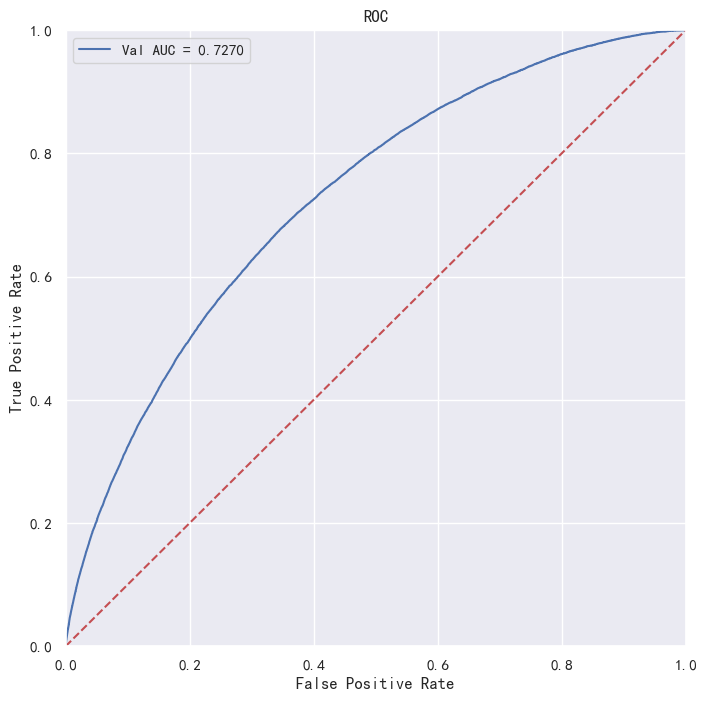

In [14]:
from sklearn import metrics
from sklearn.metrics import roc_auc_score

"""预测并计算roc的相关指标"""
val_pre_lgb = model.predict(X_val, num_iteration=model.best_iteration)
fpr, tpr, threshold = metrics.roc_curve(y_val, val_pre_lgb)
roc_auc = metrics.auc(fpr, tpr)
print('未调参前lightgbm单模型在验证集上的AUC：{}'.format(roc_auc))
"""画出roc曲线图"""
plt.figure(figsize=(8, 8))
plt.title('Validation ROC')
plt.plot(fpr, tpr, 'b', label = 'Val AUC = %0.4f' % roc_auc)
plt.ylim(0,1)
plt.xlim(0,1)
plt.legend(loc='best')
plt.title('ROC')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
# 画出对角线
plt.plot([0,1],[0,1],'r--')
plt.show()

更进一步的，使用5折交叉验证进行模型性能评估



In [15]:
cv_scores = []
for i, (train_index, valid_index) in enumerate(kf.split(X_train, y_train)):
    print('************************************ {} ************************************'.format(str(i+1)))
    X_train_split, y_train_split, X_val, y_val = X_train.iloc[train_index], y_train[train_index], X_train.iloc[valid_index], y_train[valid_index]

    train_matrix = lgb.Dataset(X_train_split, label=y_train_split)
    valid_matrix = lgb.Dataset(X_val, label=y_val)

    params = {
                'boosting_type': 'gbdt',
                'objective': 'binary',
                'learning_rate': 0.1,
                'metric': 'auc',
                'min_child_weight': 1e-3,
                'num_leaves': 31,
                'max_depth': -1,
                'reg_lambda': 0,
                'reg_alpha': 0,
                'feature_fraction': 1,
                'bagging_fraction': 1,
                'bagging_freq': 0,
                'seed': 2025,
                'nthread': 8,
                'silent': True,
                'verbose': -1,
    }

    model = lgb.train(params, train_set=train_matrix, num_boost_round=20000, valid_sets=valid_matrix, callbacks=[lgb.early_stopping(stopping_rounds=200),lgb.log_evaluation(1000)])
    val_pred = model.predict(X_val, num_iteration=model.best_iteration)

    cv_scores.append(roc_auc_score(y_val, val_pred))
    print(cv_scores)

print("lgb_scotrainre_list:{}".format(cv_scores))
print("lgb_score_mean:{}".format(np.mean(cv_scores)))
print("lgb_score_std:{}".format(np.std(cv_scores)))

************************************ 1 ************************************
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[460]	valid_0's auc: 0.729694
[0.7296937413945397]
************************************ 2 ************************************
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[635]	valid_0's auc: 0.72572
[0.7296937413945397, 0.7257197647196477]
************************************ 3 ************************************
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[469]	valid_0's auc: 0.730235
[0.7296937413945397, 0.7257197647196477, 0.7302346168205991]
************************************ 4 ************************************
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[622]	valid_0's auc: 0.728993
[0.7296937413945397, 0.7257197647196477, 0.7302346168205991, 0.728

### 贝叶斯调参

In [19]:
from sklearn.model_selection import cross_val_score

"""定义优化函数"""


def rf_cv_lgb(num_leaves, max_depth, bagging_fraction, feature_fraction, bagging_freq, min_data_in_leaf,
              min_child_weight, min_split_gain, reg_lambda, reg_alpha):
    # 建立模型
    model_lgb = lgb.LGBMClassifier(boosting_type='gbdt', bjective='binary', metric='auc',
                                   learning_rate=0.1, n_estimators=5000,
                                   num_leaves=int(num_leaves), max_depth=int(max_depth),
                                   bagging_fraction=round(bagging_fraction, 2),
                                   feature_fraction=round(feature_fraction, 2),
                                   bagging_freq=int(bagging_freq), min_data_in_leaf=int(min_data_in_leaf),
                                   min_child_weight=min_child_weight, min_split_gain=min_split_gain,
                                   reg_lambda=reg_lambda, reg_alpha=reg_alpha,
                                   n_jobs=8
                                   )

    val = cross_val_score(model_lgb, X_train_split, y_train_split, cv=5, scoring='roc_auc').mean()

    return val

In [20]:
from bayes_opt import BayesianOptimization
"""定义优化参数"""
bayes_lgb = BayesianOptimization(
    rf_cv_lgb,
    {
        'num_leaves':(10, 200),
        'max_depth':(3, 20),
        'bagging_fraction':(0.5, 1.0),
        'feature_fraction':(0.5, 1.0),
        'bagging_freq':(0, 100),
        'min_data_in_leaf':(10,100),
        'min_child_weight':(0, 10),
        'min_split_gain':(0.0, 1.0),
        'reg_alpha':(0.0, 10),
        'reg_lambda':(0.0, 10),
    }
)

"""开始优化"""
bayes_lgb.maximize(n_iter=10)

|   iter    |  target   | baggin... | baggin... | featur... | max_depth | min_ch... | min_da... | min_sp... | num_le... | reg_alpha | reg_la... |
-------------------------------------------------------------------------------------------------------------------------------------------------
| 1         | 0.7271    | 0.9931    | 11.53     | 0.521     | 10.99     | 7.394     | 63.61     | 0.4806    | 77.44     | 5.035     | 0.05619   |
| 2         | 0.7209    | 0.9812    | 50.53     | 0.9439    | 16.37     | 8.388     | 31.72     | 0.5239    | 56.71     | 0.4872    | 0.05511   |
| 3         | 0.7103    | 0.7282    | 56.53     | 0.5157    | 6.974     | 6.398     | 17.57     | 0.1437    | 193.0     | 5.971     | 2.299     |
| 4         | 0.7207    | 0.6776    | 81.37     | 0.7428    | 16.25     | 4.916     | 84.58     | 0.5109    | 33.45     | 3.469     | 5.095     |
| 5         | 0.7258    | 0.763     | 82.57     | 0.9972    | 13.72     | 7.786     | 15.33     | 0.6128    | 101.0     | 4.

In [22]:
"""显示优化结果"""
bayes_lgb.max

{'target': 0.7275442168806482,
 'params': {'bagging_fraction': 0.7006006252457107,
  'bagging_freq': 82.96446800456837,
  'feature_fraction': 0.5885852105566081,
  'max_depth': 7.199867173297536,
  'min_child_weight': 6.598336034908653,
  'min_data_in_leaf': 14.67034546089463,
  'min_split_gain': 0.49937757419359885,
  'num_leaves': 104.26693332469026,
  'reg_alpha': 9.31177341113749,
  'reg_lambda': 4.845204385655803}}

In [26]:
"""调整一个较小的学习率，并通过cv函数确定当前最优的迭代次数"""
base_params_lgb={
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'auc',
    'learning_rate': 0.01,
    'num_leaves': 37,
    'max_depth': 7,
    'min_data_in_leaf': 83,
    'min_child_weight':6.6,
    'bagging_fraction': 0.7,
    'feature_fraction': 0.58,
    'bagging_freq': 83,
    'reg_lambda': 4,
    'reg_alpha': 9,
    'min_split_gain': 0.5,
    'nthread': 8,
    'seed': 2025,
    'silent': True,
    'verbose': -1,
}

cv_result_lgb = lgb.cv(
    params=base_params_lgb,
    train_set=train_matrix,
    callbacks=[lgb.early_stopping(1000)],
    num_boost_round=20000,
    nfold=5,
    stratified=True,
    shuffle=True,
    metrics='auc',
    seed=0
)

print('迭代次数{}'.format(len(cv_result_lgb['auc-mean'])))
print('最终模型的AUC为{}'.format(max(cv_result_lgb['auc-mean'])))

Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[5971]	valid's auc: 0.731161 + 0.00119091


KeyError: 'auc-mean'

In [28]:
print('迭代次数{}'.format(len(cv_result_lgb['valid auc-mean'])))
print('最终模型的AUC为{}'.format(max(cv_result_lgb['valid auc-mean'])))

迭代次数5971
最终模型的AUC为0.7311606929249331


In [29]:
"""使用lightgbm 5折交叉验证进行建模预测"""
cv_scores = []
for i, (train_index, valid_index) in enumerate(kf.split(X_train, y_train)):
    print('************************************ {} ************************************'.format(str(i+1)))
    X_train_split, y_train_split, X_val, y_val = X_train.iloc[train_index], y_train[train_index], X_train.iloc[valid_index], y_train[valid_index]

    train_matrix = lgb.Dataset(X_train_split, label=y_train_split)
    valid_matrix = lgb.Dataset(X_val, label=y_val)

    params = {
                'boosting_type': 'gbdt',
                'objective': 'binary',
                'metric': 'auc',
                'learning_rate': 0.01,
                'num_leaves': 37,
                'max_depth': 7,
                'min_data_in_leaf': 83,
                'min_child_weight':6.6,
                'bagging_fraction': 0.7,
                'feature_fraction': 0.58,
                'bagging_freq': 83,
                'reg_lambda': 4,
                'reg_alpha': 9,
                'min_split_gain': 0.5,
                'nthread': 8,
                'seed': 2025,
                'silent': True,
                'verbose': -1,
    }

    model = lgb.train(params, train_set=train_matrix, num_boost_round=5971, valid_sets=valid_matrix,callbacks=[lgb.log_evaluation(1000),lgb.early_stopping(200)])
    val_pred = model.predict(X_val, num_iteration=model.best_iteration)

    cv_scores.append(roc_auc_score(y_val, val_pred))
    print(cv_scores)

print("lgb_scotrainre_list:{}".format(cv_scores))
print("lgb_score_mean:{}".format(np.mean(cv_scores)))
print("lgb_score_std:{}".format(np.std(cv_scores)))

************************************ 1 ************************************
Training until validation scores don't improve for 200 rounds
[1000]	valid_0's auc: 0.726817
[2000]	valid_0's auc: 0.730037
[3000]	valid_0's auc: 0.731291
[4000]	valid_0's auc: 0.731989
[5000]	valid_0's auc: 0.732504
Did not meet early stopping. Best iteration is:
[5894]	valid_0's auc: 0.73275
[0.7327504680236936]
************************************ 2 ************************************
Training until validation scores don't improve for 200 rounds
[1000]	valid_0's auc: 0.722919
[2000]	valid_0's auc: 0.726669
[3000]	valid_0's auc: 0.728136
[4000]	valid_0's auc: 0.728824
[5000]	valid_0's auc: 0.729226
Did not meet early stopping. Best iteration is:
[5937]	valid_0's auc: 0.729543
[0.7327504680236936, 0.729543133208145]
************************************ 3 ************************************
Training until validation scores don't improve for 200 rounds
[1000]	valid_0's auc: 0.727209
[2000]	valid_0's auc: 0.730

Training until validation scores don't improve for 200 rounds
[1000]	valid_0's auc: 0.725299
[2000]	valid_0's auc: 0.728653
[3000]	valid_0's auc: 0.730034
[4000]	valid_0's auc: 0.730817
[5000]	valid_0's auc: 0.731383
Early stopping, best iteration is:
[5724]	valid_0's auc: 0.731541
调参后lightgbm单模型在验证集上的AUC：0.731541105300757


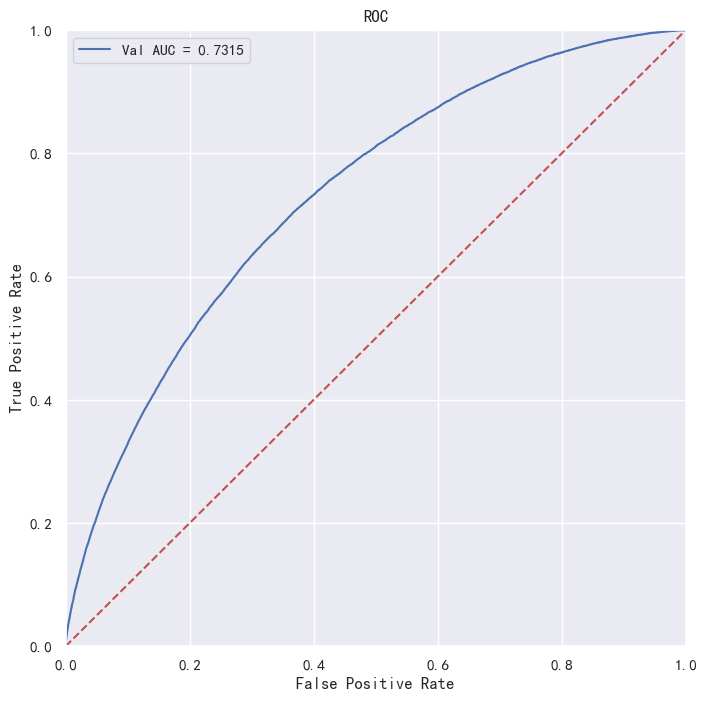

In [30]:
base_params_lgb = {
                'boosting_type': 'gbdt',
                'objective': 'binary',
                'metric': 'auc',
                'learning_rate': 0.01,
                'num_leaves': 37,
                'max_depth': 7,
                'min_data_in_leaf': 83,
                'min_child_weight':6.6,
                'bagging_fraction': 0.7,
                'feature_fraction': 0.58,
                'bagging_freq': 83,
                'reg_lambda': 4,
                'reg_alpha': 9,
                'min_split_gain': 0.5,
                'nthread': 8,
                'seed': 2025,
                'silent': True,
                'verbose': -1,
    }

"""使用训练集数据进行模型训练"""
final_model_lgb = lgb.train(base_params_lgb, train_set=train_matrix, valid_sets=valid_matrix, num_boost_round=5971, callbacks=[lgb.log_evaluation(1000),lgb.early_stopping(200)])

"""预测并计算roc的相关指标"""
val_pre_lgb = final_model_lgb.predict(X_val)
fpr, tpr, threshold = metrics.roc_curve(y_val, val_pre_lgb)
roc_auc = metrics.auc(fpr, tpr)
print('调参后lightgbm单模型在验证集上的AUC：{}'.format(roc_auc))
"""画出roc曲线图"""
plt.figure(figsize=(8, 8))
plt.title('Validation ROC')
plt.plot(fpr, tpr, 'b', label = 'Val AUC = %0.4f' % roc_auc)
plt.ylim(0,1)
plt.xlim(0,1)
plt.legend(loc='best')
plt.title('ROC')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
# 画出对角线
plt.plot([0,1],[0,1],'r--')
plt.show()

In [31]:
"""保存模型到本地"""
# 保存模型
import pickle
pickle.dump(final_model_lgb, open('model/model_lgb_best-2025-0306.pkl', 'wb'))